In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import models
from keras import layers

data_dir = '/workspace'


2025-06-07 09:38:54.286036: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-07 09:38:54.301855: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749289134.318629   26013 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749289134.323462   26013 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749289134.337173   26013 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
def plot_training_history(history):
    """
    Plot the training and validation loss and accuracy against the number of epochs.
    Parameters:
    - history: History object returned by the fit method of a Keras model
    """
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()
    

def train_model(model, model_name, X, y, epochs=100, batch_size=32, validation_split=0.2,
                optimizer='Adam', loss='binary_crossentropy',
                plot_history=True):
    """
    Trains a Keras model with the given data and saves the best weights based on validation AUC.
    Stops early if there is no improvement in validation AUC for 10 epochs.
    Using validation AUC for calculating best weights as this is the scoring critieria
    for the kaggle competition.
    Parameters:
    - model: Keras model to train.
    - model_name: String, name of the model used for naming the weights file.
    - X: Training data.
    - y: Training labels.
    - epochs: Integer, number of epochs to train.
    - batch_size: Integer, batch size for training.
    - validation_split: Float, fraction of data to use for validation.
    - optimizer: Keras optimizer.
    - loss: Keras loss function.
    - plot_history: Boolean, whether to plot the training history.
    Returns:
    - Trained Keras model with the best weights loaded.
    """
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    checkpointer = keras.callbacks.ModelCheckpoint(
        f'{model_name}.best_weights.keras', 
        save_best_only=True,
        verbose=1)
    early_stopping = keras.callbacks.EarlyStopping(
        patience=4,
        verbose=1)

    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=validation_split, 
                        callbacks=[checkpointer, early_stopping])
    
    if plot_history:
        plot_training_history(history)

    model.load_weights(f'{model_name}.best_weights.keras')
    return model # , history

 
def evaluate_model_and_print_results(model, X_test, y_test):
    """
    Evaluates the model on the test data and prints the results.
    Parameters:
    - model: Keras model to evaluate.
    - X_test: Test data.
    - y_test: Test labels.
    """
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss}')
    print(f'Test Accuracy: {test_accuracy}')
    # print(f'Test F1 Score: {test_f1score}')

In [3]:
train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'))
test_df = pd.read_csv(os.path.join(data_dir, 'test.csv'))
submission_df = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))


In [4]:
print(train_df.head())
train_df.info()

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


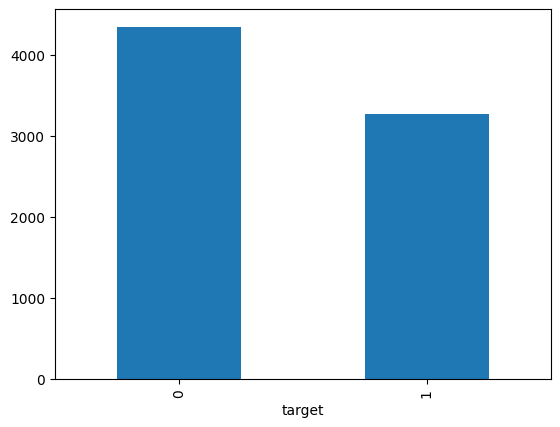

In [5]:
train_df['target'].value_counts().plot(kind='bar')
plt.show()

In [6]:
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
from wordcloud import WordCloud
import re

# TODO: Filter out URLs
# TODO: Filter out non-english text
def clean_text(text):
    text = text.lower()
    # Remove urls from text
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove html escape characters
    text = re.sub(r'&amp;', 'and', text)
    text = re.sub(r'&lt;', '<', text)
    text = re.sub(r'&gt;', '>', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    # Remove non-english characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    text = ' '.join([word for word in text.split() 
                     if word not in ENGLISH_STOP_WORDS 
                     if word not in ['s', 're', 'm', 've', 't', 'new', 'people']])
    return text



In [7]:
train_df['text'] = train_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)

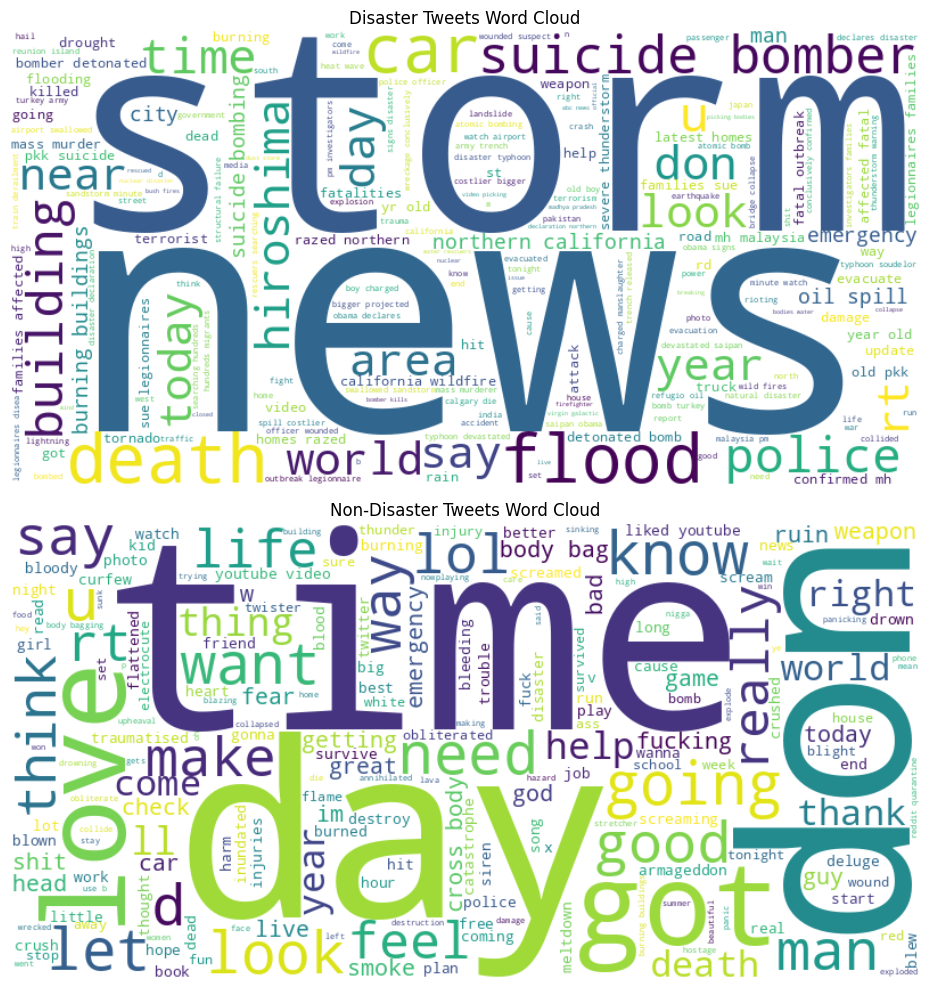

In [8]:
disaster_text = ' '.join(train_df[train_df['target'] == 1]['text'])
non_disaster_text = ' '.join(train_df[train_df['target'] == 0]['text'])

disaster_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(disaster_text)
non_disaster_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(non_disaster_text)

# Plotting wordclouds for disaster tweets and non-disaster tweets in training data
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].imshow(disaster_wordcloud, interpolation='bilinear')
ax[0].axis('off')
ax[0].set_title('Disaster Tweets Word Cloud')
ax[1].imshow(non_disaster_wordcloud, interpolation='bilinear')
ax[1].axis('off')
ax[1].set_title('Non-Disaster Tweets Word Cloud')
plt.tight_layout()
plt.show()

In [24]:
vocab_size = 20000
embedding_dim = 2000

text_vec_layer = layers.TextVectorization(max_tokens=vocab_size, output_sequence_length=128)
text_vec_layer.adapt(train_df['text'].values)

model = models.Sequential([
    # layers.InputLayer(shape=Xtrain.shape[1:]),
    text_vec_layer,
    layers.Embedding(vocab_size, embedding_dim),
    # layers.Dropout(0.2),
    # layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    # layers.Bidirectional(layers.LSTM(50, return_sequences=True)),
    # layers.Dropout(0.2),
    layers.Bidirectional(layers.LSTM(100)),
    layers.Dropout(0.2),
    layers.Dense(50, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_5            │ ?                      │   0 (unbuilt) │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6626 - loss: 0.6101
Epoch 1: val_loss improved from inf to 0.45786, saving model to lstm_model.best_weights.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6633 - loss: 0.6094 - val_accuracy: 0.7853 - val_loss: 0.4579
Epoch 2/10
187/191 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8991 - loss: 0.2651
Epoch 2: val_loss did not improve from 0.45786
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8992 - loss: 0.2650 - val_accuracy: 0.7518 - val_loss: 0.5410
Epoch 3/10
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9610 - loss: 0.1121
Epoch 3: val_loss did not improve from 0.45786
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9610 - loss: 0.1122 - val_accuracy: 0.7505 - val_loss: 0.6946
Epoch 4/10
188/191 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9717 - loss: 0.0697
Epoch 4: val_loss did not improve from 0.45786
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9717 - 

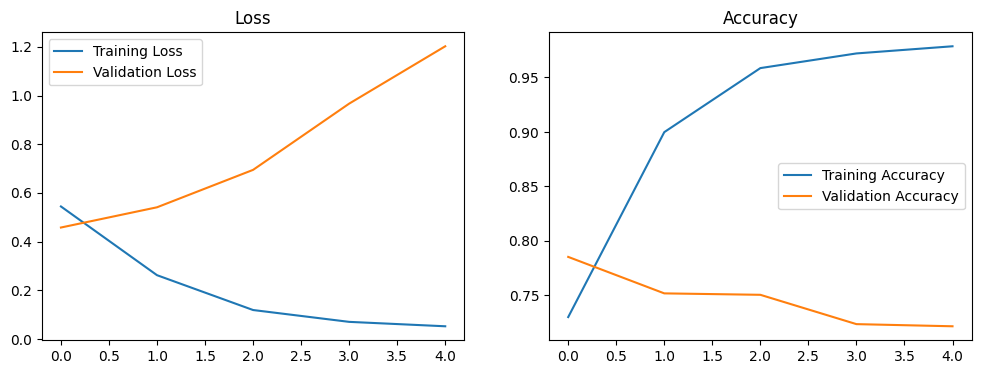

In [25]:
model = train_model(model, 'lstm_model', train_df['text'].values, train_df['target'].values,
                    epochs=10, batch_size=32)

In [26]:
#model.load_weights('lstm_with_dropout_model.best_weights.keras')
Ypred = model.predict(test_df['text'].values)
Ypred = np.round(Ypred).astype(int)
test_df['target'] = Ypred
test_df.to_csv('nlp_disaster_tweets_submission_1_layer_lstm.csv', columns=['id', 'target'], index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step   
